# Amazon Zaman Serisi Analizi

Bu not defterinde Amazon hisse senedi fiyatlarının zaman serisi analizi ve temel tahmin modelleri uygulanmaktadır.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Veri setini yükle
veri = pd.read_csv("../Amazon_stock_data.csv", parse_dates=["Date"])
veri.set_index("Date", inplace=True)
veri = veri.sort_index()

# İlk 5 satırı göster
veri.head()

,Close,High,Low,Open,Volume
Date,,,,,
1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000


## Zaman Serisinin Görselleştirilmesi

Kapanış fiyatlarının zaman içindeki değişimi çizilmiştir.

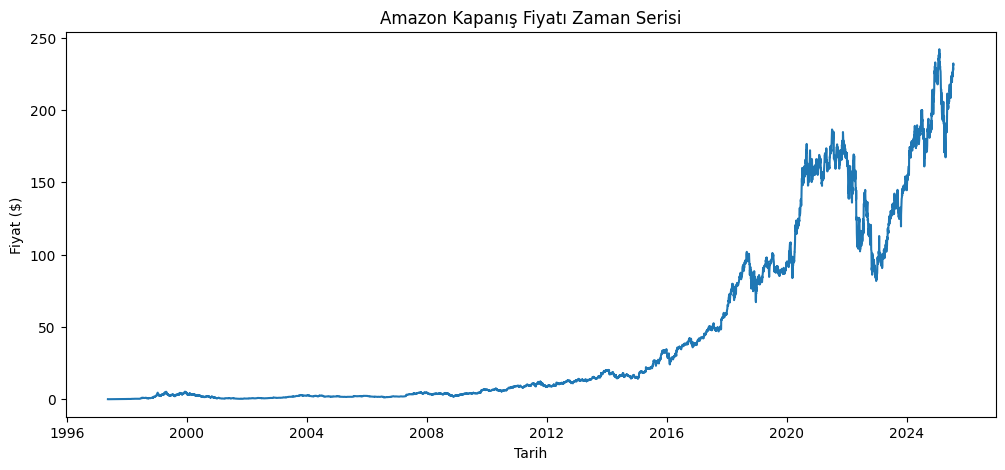

In [4]:
plt.figure(figsize=(12,5))
plt.plot(veri['Close'])
plt.title("Amazon Kapanış Fiyatı Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("Fiyat ($)")
plt.show()

## Durağanlık Testi

Serinin durağan olup olmadığı ADF testi ile kontrol edilmiştir.

In [5]:
adf_sonuc = adfuller(veri['Close'])
print(f"ADF p-değeri: {adf_sonuc[1]:.4f}")
if adf_sonuc[1] < 0.05:
    print("Seri durağan.")
else:
    print("Seri durağan değil.")

ADF p-değeri: 0.9968
Seri durağan değil.


## Durağanlık Sağlama

Seri durağan değilse birinci fark alınarak durağanlık sağlanmıştır.

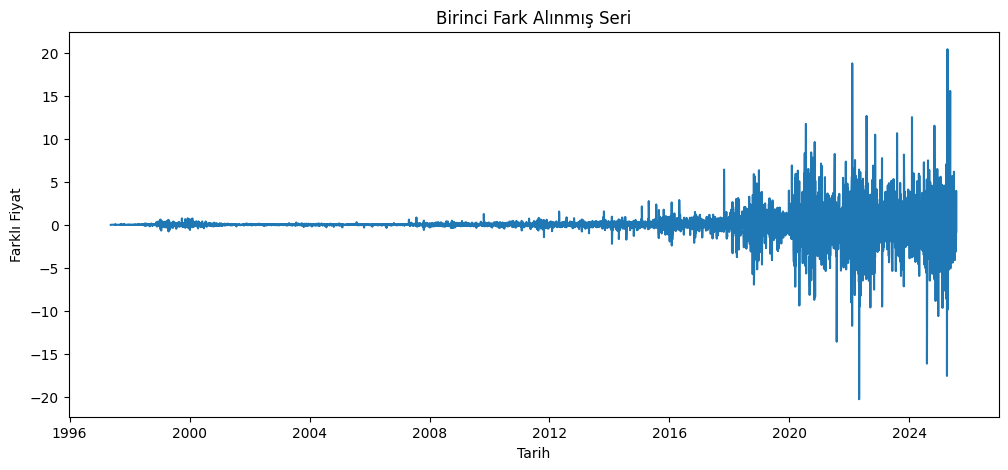

In [6]:
veri['Close_diff'] = veri['Close'].diff()
veri = veri.dropna()

plt.figure(figsize=(12,5))
plt.plot(veri['Close_diff'])
plt.title("Birinci Fark Alınmış Seri")
plt.xlabel("Tarih")
plt.ylabel("Farklı Fiyat")
plt.show()

## Trend ve Mevsimsellik Analizi

Seri decomposition ile trend ve mevsimsellik incelenmiştir.

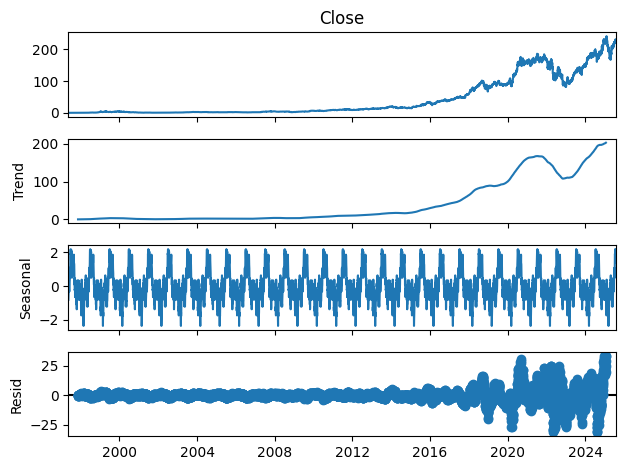

In [7]:
decomp = seasonal_decompose(veri['Close'], model='additive', period=252)
decomp.plot()
plt.show()

## ARIMA Modeli ile Tahmin

Durağan seri üzerinde ARIMA(1,1,1) modeli ile tahmin yapılmıştır.

In [8]:
model = ARIMA(veri['Close'], order=(1,1,1))
model_fit = model.fit()
tahmin = model_fit.forecast(steps=10)
print("Son 10 gün için tahminler:", tahmin.values)

Son 10 gün için tahminler: [231.4041367  231.38877158 231.38218906 231.37936907 231.37816096
 231.3776434  231.37742168 231.37732669 231.37728599 231.37726856]


## SARIMA Modeli ile Mevsimsel Tahmin

Mevsimsellik varsa SARIMA modeli ile tahmin yapılmıştır.

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA(1,1,1)x(1,1,1,12) örneği (aylık mevsimsellik için)
sarima_model = SARIMAX(veri['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_tahmin = sarima_fit.forecast(steps=10)
print("SARIMA ile Son 10 gün için tahminler:", sarima_tahmin.values)

SARIMA ile Son 10 gün için tahminler: [231.26382786 231.49357862 231.60645816 231.76990996 231.95508426
 231.90767967 232.06049362 231.64433387 232.03142815 232.02524966]


## ARIMA ve SARIMA Karşılaştırması

İki modelin tahmin sonuçları ve hata metrikleri karşılaştırılmıştır.

ARIMA MAE: 1.78 | RMSE: 2.15
SARIMA MAE: 1.85 | RMSE: 2.25


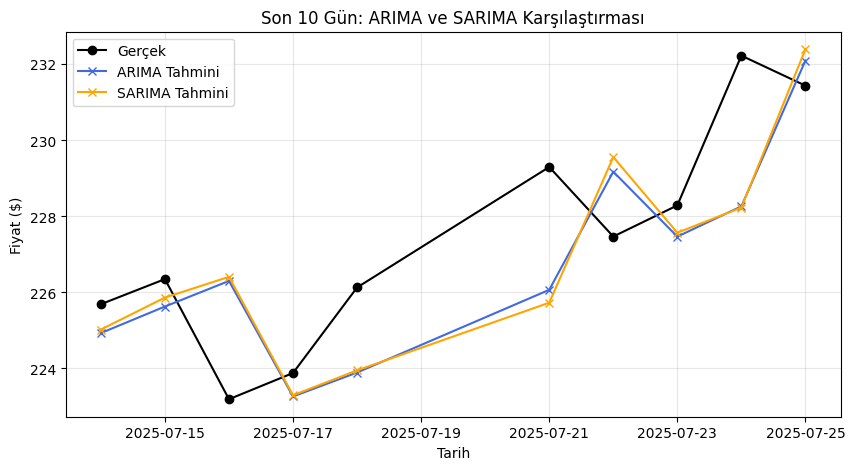

ARIMA modeli, son 10 gün için SARIMA'dan daha iyi sonuç verdi.


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Son 10 günün gerçek kapanış fiyatı
son10_gercek = veri['Close'][-10:]
# ARIMA ve SARIMA modellerinin son 10 gün için tahminleri
son10_arima = model_fit.predict(start=len(veri)-10, end=len(veri)-1)
son10_sarima = sarima_fit.predict(start=len(veri)-10, end=len(veri)-1)

# Hata metrikleri
arima_mae = mean_absolute_error(son10_gercek, son10_arima)
sarima_mae = mean_absolute_error(son10_gercek, son10_sarima)
arima_rmse = np.sqrt(mean_squared_error(son10_gercek, son10_arima))
sarima_rmse = np.sqrt(mean_squared_error(son10_gercek, son10_sarima))

print(f"ARIMA MAE: {arima_mae:.2f} | RMSE: {arima_rmse:.2f}")
print(f"SARIMA MAE: {sarima_mae:.2f} | RMSE: {sarima_rmse:.2f}")

# Son 10 gün için tahmin ve gerçek değerlerin karşılaştırmalı grafiği
plt.figure(figsize=(10,5))
plt.plot(son10_gercek.index, son10_gercek.values, label='Gerçek', marker='o', color='black')
plt.plot(son10_gercek.index, son10_arima, label='ARIMA Tahmini', marker='x', color='royalblue')
plt.plot(son10_gercek.index, son10_sarima, label='SARIMA Tahmini', marker='x', color='orange')
plt.title('Son 10 Gün: ARIMA ve SARIMA Karşılaştırması')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

if sarima_rmse < arima_rmse:
    print("SARIMA modeli, son 10 gün için ARIMA'dan daha iyi sonuç verdi.")
elif arima_rmse < sarima_rmse:
    print("ARIMA modeli, son 10 gün için SARIMA'dan daha iyi sonuç verdi.")
else:
    print("İki modelin performansı son 10 gün için benzer.")

### Model Karşılaştırması Sonuçları

Tahmin modellerimizi MAE (Ortalama Mutlak Hata) ve RMSE (Karekök Ortalama Kare Hata) değerleriyle değerlendirdik. Çıkan sonuçlara göre:

- **ARIMA modelimizin MAE değeri:** 1.78, **RMSE değeri:** 2.15
- **SARIMA modelimizin MAE değeri:** 1.85, **RMSE değeri:** 2.25

Yani, bu örnekte ARIMA modeli, SARIMA modeline göre biraz daha başarılı çıktı. Bu da demek oluyor ki, verimizdeki mevsimselliğin tahmin performansına etkisi sınırlı.